In [11]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import dash
import dash_bootstrap_components as dbc
from dash import dcc
from dash.dependencies import Input, Output
import textwrap

In [12]:
df = pd.read_excel('data.xlsx', sheet_name='Sheet1')
df2 = pd.read_excel('data.xlsx', sheet_name='Sheet2')
df3 = pd.read_excel('data.xlsx', sheet_name='Sheet3')
df = df.rename(columns={'Unnamed: 0' : 'State', 'Average of Denial_Rate' : '% of Claims Denied'})
df = df.round({'% of Claims Denied': 2})
df2 = df2.rename(columns=lambda x: x.strip())
df2 = df2.rename(columns = {'Number_Internal_Appeals_Overturned' : 'Overturned Appeals','Internal_Appeals_Upheld' : 'Upheld Appeals'})
df3 = df3.rename(columns=lambda x: x.strip())
df = pd.concat([df, pd.Series({'State' : 'CA', '% of Claims Denied' : 0.21}).to_frame().T], ignore_index=True)
df2 = pd.concat([df2, pd.Series({'State' : 'CA', 'Internal_Appeals_Filed' : 16490, 
                           'Overturned Appeals' : 6309, 'Upheld Appeals' : 16490-6309}).to_frame().T], ignore_index=True)
df['% of Claims Denied'] = df['% of Claims Denied'].astype(float)
df.sort_values(by='State', inplace=True)
df.reset_index(drop=True, inplace=True)
df2.sort_values(by='State', inplace=True)

In [13]:
il_df = pd.read_excel('California Denied Claims.xlsx', 'Sheet1')
pl_df = pd.read_excel('California Denied Claims.xlsx', 'Sheet2')
pl_df2 = pl_df.transpose(copy=True)
il_df2 = il_df.transpose(copy=True)
il_df2.columns = il_df2.iloc[0]
il_df2 = il_df2.iloc[1:]
pl_df2.columns = pl_df2.iloc[0]
pl_df2 = pl_df2.iloc[1:]

il_df2.drop(['Issuer HIOS ID*', 'In-Network Claims That Were Denied ', 'In-Network Claims That Were Received ',
            'In-Network Claims That Were Resubmitted ', 'Out-of-Network Claims That Were Denied ',
            'Out-of-Network Claims That Were Received ', 'Out-of-Network Claims That Were Resubmitted '], axis=1, inplace=True)

pl_df2.drop([' In Network Claims That Were Received in 2023', ' In Network Claims with That Were Denied in 2023',
            ' In Network Claims That Were Resubmitted in 2023', ' Out-of-Network Claims That Were Received in 2023',
            ' Out-of-Network Claims That Were Denied in 2023', ' Out-of-Network Claims That Were Resubmitted in 2023'], axis=1, inplace=True)
pl_df2 = pl_df2.iloc[:, 3:]
pl_df2.insert(0, 'State', 'CA')
pl_df2.rename(columns = {' Prior Authorization or Referral Required ': 'Referral Required',
                        ' Exclusion of a Service ' : 'Services Excluded', 
                        ' Lack of Medical Necessity, excluding Behavioral Health ' : 'Not Medically Necessary Excluding Behavioral Health',
                        ' an Out-Of-Network Provider/Claims ' : 'Out Of Network',
                        ' Lack of Medical Necessity, Behavioral Health only' : 'Not Medically Necessary Only Behavioral Health',
                        ' Enrollee Benefit Limit Reached ' : 'Enrollee Benefit Limit Reached',
                        ' Member Not Covered During All or Part of Date of Service ' : 'Member Not Covered',
                        ' Investigational, Experimental, or Cosmetic Procedure ' : 'Investigational Experimental Cosmetic Procedure',
                        ' Administrative Reasons ' : 'Administrative Reason',
                        'Other Reasons ' : 'Other'}, inplace=True)
pl_df2['Not Medically Necessary'] = pl_df2['Not Medically Necessary Excluding Behavioral Health'] + pl_df2['Not Medically Necessary Only Behavioral Health']
pl_df2.columns.name = None
df3 = pd.concat([df3, pl_df2])
df3.sort_values(by='State', inplace=True)
df3.reset_index(drop=True, inplace=True)

In [14]:
states = gpd.read_file("states.shp")
def choropleth_plot():
    fig = px.choropleth(df,
                    locations=df['State'],
                    locationmode="USA-states",
                    color=df['% of Claims Denied'] * 100,
                    color_continuous_scale="Viridis",
                    scope="usa",
                    title='Denial Rate of Claims Per State (2023)')
    fig.add_annotation(
      text="Centers for Medicare & Medicaid Services,  \"Transparency in Coverage PUF (TC-PUF)\", 2023, <br> \
      https://www.cms.gov/marketplace/resources/data/public-use-files",
      xref="paper", yref="paper",
      x=0.75, y=-0.1,
      showarrow=False,
      xanchor="right", yanchor="bottom")
    fig.update_layout(title = {'x': 0.25, 'y': 0.95},
                      margin = dict(t=50, r=25,  l=25),
                      coloraxis_colorbar_title_text = '% of Claims Denied')
    fig.update_traces(customdata=np.stack((df['State'], (df['% of Claims Denied'] * 100).round()), axis=-1),
                      hovertemplate='<br>'.join([
                      "State: %{customdata[0]}",
                      "Percent: %{customdata[1]}"
                      ]))
    return fig

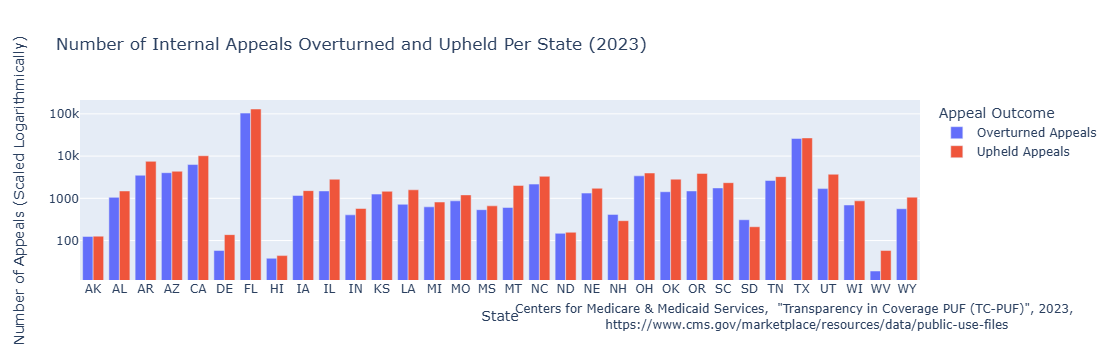

In [15]:
df2_melted = pd.melt(df2, id_vars=['State'],
                     value_vars=['Overturned Appeals', 'Upheld Appeals'],
                     var_name='Appeal Outcome', value_name='Count')
fig2 = px.bar(
    df2_melted,
    x="State",
    y="Count",
    log_y=True,
    labels={'Count': 'Number of Appeals (Scaled Logarithmically)'},
    color="Appeal Outcome",
    color_continuous_scale='Viridis',
    barmode="group",
    title="Number of Internal Appeals Overturned and Upheld Per State (2023)"
    )
fig2.add_annotation(
    text="Centers for Medicare & Medicaid Services,  \"Transparency in Coverage PUF (TC-PUF)\", 2023, <br> \
    https://www.cms.gov/marketplace/resources/data/public-use-files",
    xref="paper", yref="paper",
    x=1.19, y=-0.3,
    showarrow=False,
    xanchor="right", yanchor="bottom" )
fig2.show()

In [31]:
def wrap_labels(labels, width=20):
    return ['<br>'.join(textwrap.wrap(label, width=width)) for label in labels]
def treemap_plot(state):
    state_data = df3[df3['State'] == state].iloc[:, 1:]
    state_data.columns = wrap_labels(state_data.columns)
    other = state_data.pop('Other')
    other_percent = int((other / (state_data.sum().sum() + other)*100).iloc[0])
    flat_data = state_data.values.flatten().tolist()
    flat_data = [1 if x == 0 else x for x in flat_data]
    fig = px.treemap(state_data,
                    path=[state_data.columns],
                    values=flat_data,
                    color=flat_data,
                    color_continuous_scale='PuBu',
                    title=f'Reasons for Claim Denials in {state}')
    fig.data[0].textinfo = 'label+percent parent'
    fig.add_annotation(
      text=f'\"Other\" accounts for {other_percent}% of denial reasons',
      x=0, y=1.15,
      showarrow=False)
    fig.update_layout(uniformtext=dict(minsize=15, mode='hide'),)
    fig.update(layout_coloraxis_showscale=False)
    if state == 'CA':
        fig.add_annotation(
        text="Covered California, \"Data on Denied Claims\", 2023, <br>\
        https://hbex.coveredca.com/insurance-companies/denied-claims/",
        xref="paper", yref="paper",
        x=0.75, y=-0.2,
        showarrow=False,
        xanchor="right", yanchor="bottom" )
    else:
        fig.add_annotation(
        text="Centers for Medicare & Medicaid Services, \"Transparency in Coverage PUF (TC-PUF)\", 2023, <br>\
        https://www.cms.gov/marketplace/resources/data/public-use-files",
        xref="paper", yref="paper",
        x=0.75, y=-0.2,
        showarrow=False,
        xanchor="right", yanchor="bottom" )
    fig.update_traces(hovertemplate='labels=%{label}<br>value=%{value}<extra></extra>')
    return fig

In [30]:
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
app.layout = dbc.Container([
    dbc.Card([
            dbc.Button('🡠',
                       id='back-button',
                       outline=True,
                       size="sm",
                       className='mt-2 ml-2 col-1',
                       style={'display': 'none'}
                       ),
            dbc.Row(
                dcc.Graph(
                        id='graph',
                        figure=choropleth_plot()
                        ),
                justify='center'
            )
            ], className='mt-3')
])

@app.callback(
    Output('graph', 'figure'),
    Output('back-button', 'style'), 
    Input('graph', 'clickData'),    
    Input('back-button', 'n_clicks')
    )
def drilldown(click_data,n_clicks):
    ctx = dash.callback_context
    trigger_id = ctx.triggered[0]["prop_id"].split(".")[0]
    if trigger_id == 'graph':
        if click_data:
            state = click_data['points'][0]['location']
            if state in df3['State'].unique():
                fig = treemap_plot(state)
                return fig, {'display':'block'}     
            else:
                return choropleth_plot(), {'display': 'none'}    
    else:
        return choropleth_plot(), {'display':'none'}

if __name__ == '__main__':
    app.run_server(debug=False)

CA
AZ
